In [25]:
import pandas as pd; pd.set_option('display.max_columns', 30); pd.set_option('display.max_rows', 100)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter, ResampleFilter, MorletWaveletFilter
import xarray as xarray
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
from scipy.stats import zscore
import seaborn as sns
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/johnModules')
from brain_labels import HPC_labels, ENT_labels, PHC_labels, temporal_lobe_labels,\
                         MFG_labels, IFG_labels, nonHPC_MTL_labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *
import statsmodels.formula.api as smf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
class ripple_analysis():

    def __init__(self, exp, df, ripple_bin_start_end=[100,1700], pre_encoding_time=-700, encoding_time=2300, bin_size=100,
                            smoothing_triangle=5, samples=100):

        self.exp = exp
        self.df = df 
        self.ripple_bin_start_end = ripple_bin_start_end
        self.pre_encoding_time = pre_encoding_time
        self.encoding_time = encoding_time
        self.bin_size = bin_size
        self.smoothing_triangle = smoothing_triangle
        self.samples = samples 

    def remove_subject_sessions(self):
        
        # 575 FR sessions. first 18 of don't load so skip those 
        exp_df = self.df[self.df.experiment==self.exp]
        if self.exp == 'FR1':
            exp_df = exp_df[
                            ((self.df.subject!='R1015J') | (self.df.session!=0)) & 
                            ((self.df.subject!='R1063C') | (self.df.session!=1)) & 
                            ((self.df.subject!='R1093J') | (~self.df.session.isin([1,2]))) &
                            ((self.df.subject!='R1100D') | (~self.df.session.isin([0,1,2]))) &
                            ((self.df.subject!='R1120E') | (self.df.session!=0)) &
                            ((self.df.subject!='R1122E') | (self.df.session!=2)) &
                            ((self.df.subject!='R1154D') | (self.df.session!=0)) &
                            ((self.df.subject!='R1186P') | (self.df.session!=0)) &
                            ((self.df.subject!='R1201P') | (~self.df.session.isin([0,1]))) &
                            ((self.df.subject!='R1216E') | (~self.df.session.isin([0,1,2]))) &
                            ((self.df.subject!='R1277J') | (self.df.session!=0)) &
                            ((self.df.subject!='R1413D') | (self.df.session!=0)) & 
                            ((self.df.subject!='R1123C') | (self.df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                            ((self.df.subject!='R1151E') | (~self.df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                            ((self.df.subject!='R1275D') | (self.df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
            #                 (self.df.subject!='R1065J') # sub with 9000 trials
                        ] 
        elif self.exp == 'catFR1': 
            exp_df = exp_df[
                            ((self.df.subject!='R1044J') | (self.df.session!=0)) & # too few trials to do pg pairwise corr
                            ((self.df.subject!='R1491T') | (~self.df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                            ((self.df.subject!='R1486J') | (~self.df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                            ((self.df.subject!='R1501J') | (~self.df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                            ((self.df.subject!='R1235E') | (self.df.session!=0)) & # split EEG filenames error...documented on Asana
                            ((self.df.subject!='R1310J') | (self.df.session!=1)) & # session 1 is just a repeat of session 0
                            ((self.df.subject!='R1239E') | (self.df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
            ]
        elif self.exp == 'RepFR1':
            exp_df = exp_df[
                            (self.df.subject!='R1564J') # clearly something wrong with these EEG when looking at ripple raster
                            ]
        # exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
        # exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
        # exp_df = exp_df[4:7]
        self.exp_df = exp_df


    def load_data_from_cluster(self, selected_period, region_name='HPC', filter_type='hamming',
    sub_selection='first_half', remove_soz_ictal=0, recall_type_switch=0, hpc_ripples=False):

        '''
        :param str selected_period: input one of the following options
            'surrounding_recall': aligned to time of free recall 
            'whole_retrieval': aligned to beginning of retrieval period (beep_off)
            'encoding': aligned to word_on
            'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
                       NOTE: this analysis is in SWRanalysis-encoding.ipynb now
            'math': aligned to math problem on
            'math_retrieval': aligned to math problem key-in time
        :param str region_name: input can be ENT, HPC, HPC_ENT ENT, HPC, PHC, TEMPORALLOBE, IFG, MFG, ENTPHC, AMY
        :param str remove_soz_ictal: input 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
        :param str filter_type: input can be butter/hamming/hamming125200/tried hamming140250 for math
        :param str sub_selection: input can be second_half (remaining 60%), whole , first_half (first 40%), works for FR1 and catFR1
        :param bool hpc_ripples: if true, only load sessions which have both HPC data and region name data, and use ripples from HPC 
        '''

        self.filter_type = filter_type
        self.files_loaded_amy = 0
        self.files_loaded_hpc = 0

        recall_minimum = 2000 # used if recall_type_switch = 3

        # get strings for path name for save and loading cluster data
        if recall_type_switch in [0,4,6,8]:
            # for these I'm using all trials, but selecting for which recall after the fact
            soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period, recall_minimum)
        else: # these others I haven't set up indexing (see >line 100 in this cell)
            soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period, recall_minimum)
            
        ripple_array = []; ripple_array_hpc = []; HFA_array = []
        trial_nums = []; trial_nums_hpc = []; encoded_word_key_array = []
        HPC_names = []; HPC2_names = []; sub_sess_names = []; sub_sess_names_HPC = []
        region_electrode_ct = []; sub_names = []
        trial_by_trial_correlation = []; elec_ripple_rate_array = []
        elec_by_elec_correlation = []; fr_array = []
        list_num_key = []

        serialpos_array = []; list_recall_num_array = []; # ~~~
        rectime_array = []; recall_before_intrusion_array = []
        recall_position_array = []; session_events = pd.DataFrame()

        electrode_labels = []; channel_coords = []; channel_nums = []

        analysis_df = getSplitDF(self.exp_df,sub_selection, self.exp)

        for row in analysis_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  
            try:

                sub = row.subject; session = row.session; exp = row.experiment

                path_name = '/scratch/john/SWR_scratch/'+subfolder
                fn = os.path.join(path_name,
                    'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                                '_'+soz_label+'_'+filter_type+'.p') #'-NOCUTOFFS.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
                                # -NOCUTOFFS for Vaz filter for Norman/Staresina comparison
                
                print("Filename: ", fn)
                with open(fn,'rb') as f:
                    
                    self.files_loaded_amy += 1
                    dat = pickle.load(f)
                    ripple_array= superVstack(ripple_array,dat['ripple_array'])
                    print("Ripple array shape", ripple_array.shape)
                    HFA_array = superVstack(HFA_array,dat['HFA_array'])
                    region_electrode_ct.append(dat['region_electrode_ct'])
                    encoded_word_key_array.extend(dat['encoded_word_key_array'])
                    region_names_file = dat['HPC_names']
                    HPC_names.extend(dat['HPC_names'])
                    sub_sess_names.extend(dat['sub_sess_names'])
                    sub_names.extend(dat['sub_names'])
                    trial_nums = np.append(trial_nums,dat['trial_nums'])
                    trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
                    elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
                    elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
                    #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
                    if selected_period == 'whole_retrieval':
                        if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                            print(sub+str(session))
                        fr_array = superVstack(fr_array,dat['fr_array'])
                    elif selected_period == 'encoding':
                        serialpos_array.extend(dat['serialpos_array'])
                        session_events = session_events.append(dat['session_events']) # doesn't append in place 
                    elif selected_period == 'surrounding_recall': # ~~~
                        serialpos_array.extend(dat['serialpos_array']); list_recall_num_array.extend(dat['list_recall_num_array']); # ~~
                        rectime_array.extend(dat['rectime_array']); recall_before_intrusion_array.extend(dat['recall_before_intrusion_array'])
                        recall_position_array.extend(dat['recall_position_array'])
                                    
                    elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
                        rectime_array.extend(dat['rectime_array'])
                        recall_position_array.extend(dat['recall_position_array']); list_recall_num_array.extend(dat['list_recall_num_array'])
                    elif selected_period == 'whole_encoding':
                        serialpos_array.extend(dat['serialpos_array']); recall_position_array.extend(dat['recall_position_array'])
                        list_recall_num_array.extend(dat['list_recall_num_array']); 

                    electrode_labels.extend(dat['electrode_labels'])
                    channel_coords.extend(dat['channel_coords'])
                    channel_nums.extend(dat['channel_nums'])
                    list_num_key.extend(dat['list_num_key'])

                
                # if conditioning on HPC ripples
                if region_name != 'HPC' and hpc_ripples:

                    fn_HPC = os.path.join(path_name,
                    'SWR_'+exp+'_'+sub+'_'+str(session)+'_HPC_'+selected_period+recall_selection_name+
                                '_'+soz_label+'_'+filter_type+'.p')

                    with open(fn_HPC, 'rb') as fh:

                        dat_HPC = pickle.load(fh)

                        ripple_array_hpc = superVstack(ripple_array_hpc, dat_HPC['ripple_array'])
                        trial_nums_hpc = np.append(trial_nums_hpc, dat_HPC['trial_nums'])
                        HPC2_names.extend(dat_HPC['HPC_names'])

                    # reload ripples with hpc ripples
                    ripple_array = self.ripples_hpc(trial_nums, HPC_names, ripple_array, trial_nums_hpc, HPC2_names, ripple_array_hpc)
                    print("Ripple array shape (modified", ripple_array.shape)
                    
                    
            except Exception as e:
                LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  


        print('**Done reading data**')

                
        ## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

        # trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
        # (this way I can always load from recall_type_switch = 0)

        subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
                sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)

        if selected_period == 'surrounding_recall':
            if recall_type_switch == 4:
                temp_recall_idxs = np.array(recall_position_array)==1
            elif recall_type_switch == 6:
                temp_recall_idxs = np.array(recall_position_array)>1
            elif recall_type_switch == 8:
                temp_recall_idxs = np.array(recall_position_array)==2
            else:
                temp_recall_idxs = np.array(recall_position_array)>=0
            self.serialpos_array = np.array(self.serialpos_array)[temp_recall_idxs]
            recall_before_intrusion_array = np.array(recall_before_intrusion_array)[temp_recall_idxs]
            self.list_num_key = np.array(list_num_key)[temp_recall_idxs]
        elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
            temp_recall_idxs = np.array(recall_position_array)>=0 # just keep them all for math
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
        elif selected_period == 'whole_encoding':
            temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
        elif selected_period == 'encoding':
            temp_recall_idxs = np.ones(len(session_name_array))==1 # just keep them all
            self.session_events = session_events[temp_recall_idxs]
            
            # spread out encoded_word_key too so I know which words were correct
            self.word_correct_array = []
            for sess_elec in encoded_word_key_array:
                self.word_correct_array.append(sess_elec)
            self.word_correct_array = np.array(self.word_correct_array)
            self.word_correct_array[self.word_correct_array>0] = 1 # 1s and 2s are corrects
            
        self.subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
        self.session_name_array = np.array(session_name_array)[temp_recall_idxs]
        self.electrode_array = np.array(electrode_array)[temp_recall_idxs]
        self.channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
        self.channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
        self.ripple_array = np.array(ripple_array)
        #self.ripple_array = self.ripple_array_full[temp_recall_idxs]

        self.HFA_array = np.array(HFA_array)[temp_recall_idxs]


        if exp == 'surrounding_recall':
            self.rectime_array = np.array(rectime_array)[temp_recall_idxs]
            self.list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
            self.recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
            
        print('**Done translating to ripple_array frame**!!')
        print('...')
        print('% of all HPC subjects for '+exp)
        if exp == 'catFR1':
            len(np.unique(sub_names))/136*100 # % HPC subs for catFR1
            print('% of HPC recalls for '+exp)
            self.ripple_array.shape[0]/50053*100 # % recalls for catFR1
        if exp == 'FR1':
            len(np.unique(sub_names))/167*100 # % HPC subs for FR1
            print('% of HPC recalls for '+exp)
            self.ripple_array.shape[0]/60417*100 # % recalls for FR1

        region_electrode_ct = np.array(region_electrode_ct)
        # print('Number of electrodes in each session: '); region_electrode_ct
        print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
        print('Total trials: '+str(int(np.sum(trial_nums))))
        print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
        print('...from '+str(len(np.unique(subject_name_array)))+' patients')

        # some info about regions 
        sub_elec = [subject_name_array[i]+self.electrode_array[i] for i in range(len(self.electrode_array))]
        print('Number of electrodes: '+str(len(np.unique(sub_elec))))

        print('Electrode regions X sessions:')
        unique_names = np.unique(HPC_names)
        for name in unique_names:
            num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
            print(str(num_elecs)+' for '+name)

        self.trial_nums = trial_nums
        self.sub_sess_names = sub_sess_names
        self.HPC_names = HPC_names
        self.recall_before_intrusion_array = recall_before_intrusion_array
        self.rectime_array = rectime_array
        self.list_recall_num_array = list_recall_num_array
        self.temp_recall_idxs = temp_recall_idxs
        self.selected_period = selected_period
        self.sub_names = sub_names
        self.serialpos_array = serialpos_array
        self.region_name = region_name 

    def ripples_hpc(self, nonhpc_trialnums, nonhpc_regions, ripple_array_nonhpc,
                 hpc_trialnums, hpc_regions, ripple_array_hpc):

        '''
        Replaces ripples from nonhpc region with hpc ripples from corresponding hemisphere. 
        '''

        timesteps = ripple_array_nonhpc.shape[1]

        # Step 1: Separate hpc right and left ripples
        # only select ripples from ca1 or dg 
        left_hemi_data = []
        right_hemi_data = []
        trialStart = 0
        for region, trials in zip(hpc_regions, hpc_trialnums):
            trials = int(trials)
            if 'right ca1' in region or 'right dg' in region:
                right_hemi_data.append(ripple_array_hpc[trialStart:trialStart+trials])
            if 'left ca1' in region or 'left dg' in region: 
                left_hemi_data.append(ripple_array_hpc[trialStart:trialStart+trials])
            trialStart += trials 

        # average over all ripples in each hemisphere
        # clip array at 1, b/c it doesn't matter if a ripple was detected across multiple electrodes
        # at the same time. The resulting array will be of shape trials x timesteps. 
        # If there are no ripples in a hemi, then fill an array of that shape with all zeros. 
        if len(right_hemi_data) > 0:
            rhd_np = np.clip(np.sum(np.stack(right_hemi_data),axis=0), a_min=0, a_max=1)
        else:
            rhd_np = np.zeros_like((trials, timesteps))
        if len(left_hemi_data) > 0:
            lhd_np = np.clip(np.sum(np.stack(left_hemi_data),axis=0), a_min=0, a_max=1)
        else:
            lhd_np = np.zeros_like((trials, timesteps))

        # fill an array of the same shape as the nonhpc ripples with the averaged hpc ripples
        # from the correct hemisphere. 
        ripples_hpc_nonhpcshape = np.zeros_like(ripple_array_nonhpc)
        trialStart = 0
        for region, trials in zip(nonhpc_regions, nonhpc_trialnums):
            trials = int(trials)
            if 'right' in region:
                ripples_hpc_nonhpcshape[trialStart:trialStart+trials] = rhd_np
            if 'left' in region:
                ripples_hpc_nonhpcshape[trialStart:trialStart+trials] = lhd_np

            trialStart += trials 

        return ripples_hpc_nonhpcshape

    def getStartArray(self, region_selection=['ca1', 'dg'], select_subfield=True):

        '''
        :param str region_selection: can be dg, ca3, dg, ca1, sub, 'ca1, dg
        @param select_subfield: bool, set to FALSE for ENT or PHC, only can be TRUE for HPC

        '''
            
        # select for subfield if HPC, EF1208
        if select_subfield == True and self.region_name=='HPC':
            location_selected = region_selection
                # left # right # left hippocampus # right hippocampus # hippocampus
                # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
        else:
            location_selected = ''

        ### Use a task condition to select recalls?? ###
        ### ...will select first one that's not 0    ###
        select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
        select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                                # 0 means it's off. Must be list
        select_less_than_rectime = 0             # select only recalls < this number % 5000
        select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
        select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                                # select only recalls that come from lists with number in this list
        select_intrusions_next = 0               # select recalls that lead to intrusions
            
        if self.filter_type.find('hamming') != -1:
            desired_sample_rate = 500.
        else:
            desired_sample_rate = 1000.
        sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
        sr_factor = 1000/desired_sample_rate

        print('Total electrodes loaded: '+str(len(self.trial_nums)))
        print('from '+str(len(np.unique(self.sub_sess_names)))+' sessions from '+str(len(np.unique(self.sub_names)))+' subjects with trial nums:')
        print('Trial sum = '+str(np.sum(self.trial_nums)))
        print('Number of sub_sess names: '+str(len(self.sub_sess_names)))

        start_array,end_array = getStartEndArrays(self.ripple_array) # get start array
        
        # if selected an output position
        if select_ordinal_position > 0:
            if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
                ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
            selected_recalls = ordinal_position_array==select_ordinal_position
        elif type(select_list_position) == list:
            selected_recalls = [sp in select_list_position for sp in self.serialpos_array]
        elif select_intrusions_next == 1:
            selected_recalls = np.array(self.recall_before_intrusion_array)==True
        elif select_less_than_rectime > 0:
            selected_recalls = np.array(self.rectime_array)<select_less_than_rectime
        elif select_greater_than_rectime > 0:
            selected_recalls = np.array(self.rectime_array)>=select_greater_than_rectime
        elif type(select_lists_with_recalls) == list:
            selected_recalls = [recall in select_lists_with_recalls for recall in self.list_recall_num_array]
        else:
            selected_recalls = np.ones(len(start_array),dtype=bool)
            
        # get locations if selected
        if select_subfield == True:
            # create the full vector of location name predictors
            location_names = []
            for s in range(len(self.HPC_names)):
                new_trials = int(self.trial_nums[s])
                location_names.extend(np.tile(self.HPC_names[s],new_trials))  
                
            # now can get mask of trials in this location
            
            #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
            location_mask = np.zeros(len(location_names))
            for s in range(len(location_names)):
                if type(location_selected)==list:
                    if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                        location_mask[s] = True
                elif type(location_selected)==str:
                    if location_names[s].find(location_selected)>=0:
                        location_mask[s] = True
        else:
            location_mask = np.ones(len(start_array))

        # gotta translate this to new frame as well from idxs in load step if selected subfield
        if select_subfield == True: 
            location_mask = location_mask[self.temp_recall_idxs] 

        # combine location and sorted recalls to get new ripple array:
        updated_recalls = (location_mask+selected_recalls)==2

        print(len(self.serialpos_array))
            
        # translate these predictors to vector and select recalls
        self.start_array = start_array[updated_recalls]
        self.end_array = end_array[updated_recalls] # used for duration calculations
        self.subject_name_array = np.array(self.subject_name_array)[updated_recalls]
        self.session_name_array = np.array(self.session_name_array)[updated_recalls]
        self.electrode_array = np.array(self.electrode_array)[updated_recalls]
        self.channel_coords_array = np.array(self.channel_coords_array)[updated_recalls]
        self.channel_nums_array = np.array(self.channel_nums_array)[updated_recalls]
        # if selected_period in ['surrounding_recall','math','math_retrieval']:
        #     list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
        #     rectime_array = np.array(rectime_array)[updated_recalls]
        if self.selected_period == 'surrounding_recall':
            self.list_num_key = self.list_num_key[updated_recalls]
        if self.selected_period == 'encoding':
            self.word_correct_array = self.word_correct_array[updated_recalls]
            self.serialpos_array = np.array(self.serialpos_array)[updated_recalls]
        #     session_events = session_events[updated_recalls]


        print(f"HFA Array shape: {self.HFA_array.shape}")
        print(f"Updated recalls shape: {updated_recalls.shape}")
        self.HFA_array = self.HFA_array[updated_recalls,:]
        self.ripple_array = self.ripple_array[updated_recalls, :] # EF1208
            
            
        print('Got start_array with '+str(start_array.shape[0])+' trials!')

        sub_elec = [self.subject_name_array[i]+self.electrode_array[i] for i in range(len(self.electrode_array))]


    def ripple_idxs_func(self):

        '''
        Returns idxs of ripples and no ripples from ripple_array
        '''

        start = -700
        end = 2300

        start_marker = int((self.ripple_bin_start_end[0] - start) / 2.0)
        end_marker = int((end - self.ripple_bin_start_end[1]) / 2.0)

        # Not sure what to do with 0.5 values right now, so going to remove them.
        ripple_array_binary = np.where(self.ripple_array==0.5, 0, self.ripple_array)
        print(f"Unique values in ripple array {np.unique(ripple_array_binary)}")

        # sum across rows to find rows where a ripple occurs
        ripple_array_rowsum = np.sum(ripple_array_binary[:, start_marker:-end_marker],axis=1)
        ripple_bool = np.where(ripple_array_rowsum==0, False, True) 
        ripple_idxs = np.squeeze(np.argwhere(ripple_bool==True))
        non_ripple_idxs = np.squeeze(np.argwhere(ripple_bool==False))
        print(f"Number of events where a ripple occured {ripple_idxs.shape[0]}")
        print(f"Number of events with no ripples {non_ripple_idxs.shape[0]}")

        return ripple_idxs, non_ripple_idxs

    def plot_SME_HFA(self, mode, title_str, savePath):

        '''
        :param int mode: 0 for all using all HFA activity, 1 for only ripples, and 2 for only non-ripples 
        '''
        pad = int(np.floor(self.smoothing_triangle/2)) 
        
        if mode == 1: 
            ripple_idxs, _ = self.ripple_idxs_func()
            HFA_array = self.HFA_array[ripple_idxs]
            word_correct_array = self.word_correct_array[ripple_idxs]
            subject_name_array = self.subject_name_array[ripple_idxs]
            session_name_array = self.session_name_array[ripple_idxs]
        if mode == 2: 
            _, non_ripple_idxs = self.ripple_idxs_func()
            HFA_array = self.HFA_array[non_ripple_idxs]
            word_correct_array = self.word_correct_array[non_ripple_idxs]
            subject_name_array = self.subject_name_array[non_ripple_idxs]
            session_name_array = self.session_name_array[non_ripple_idxs]
        
        plot_ME_mean = 1 # 0 for typical PSTH, 1 for ME mean, 2 for average across sub averages
        save_plot_data = 0

        ytextshift = 0

        # set up the PVTH stats parameters here too (for encoding have 30 bins)

        psth_start = int(self.pre_encoding_time/self.bin_size)
        psth_end = int(self.encoding_time/self.bin_size)
        sr_factor = 1 # already at 100 ms resolution with these bins

        bin_centers = np.arange(psth_start+0.5,psth_end)
        xr = bin_centers #np.arange(psth_start,psth_end,binsize)

        # get vectors of encoding list identifier data for forgotten and recalled words
        # in encoded_word_key_array, 0 for not recalled, 1 for recalled, 2 for recalled but was an IRI<2 (don't care about that for encoding)
        start_array_enc_forgot = HFA_array[word_correct_array==0]
        start_array_enc_recalled = HFA_array[word_correct_array==1]

        # same for sub and sess
        sub_forgot = np.array(subject_name_array)[word_correct_array==0]
        sess_forgot = np.array(session_name_array)[word_correct_array==0]
        sub_recalled = np.array(subject_name_array)[word_correct_array==1]
        sess_recalled = np.array(session_name_array)[word_correct_array==1]

        # record min and max value before separating into recalled and not recalled in order to write text
        PSTH_all = triangleSmooth(np.mean(HFA_array,0),self.smoothing_triangle)
        min_val_PSTH = np.min(PSTH_all)
        max_val_PSTH = np.max(PSTH_all)

        # for recalled and then forgotten words
        for category in range(2):
            if category == 0:
                temp_start_array = start_array_enc_recalled
                sub_name_array = sub_recalled
                sess_name_array = sess_recalled
                     
                # HFA 
                PSTH = triangleSmooth(np.mean(temp_start_array,0),self.smoothing_triangle)

                # for plot
                subplots(1,1,figsize=(5,4))
                #label = 'List words later \\textbf{recalled}'
                plot_color = (0,0,1)
                #text(0.05, max_val_PSTH+0.32 ,label,usetex=True,size=16,color=plot_color)
                #text(0.05, max_val_PSTH+0.24,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
                num_words = f"Recalled: {temp_start_array.shape[0]}"

            else:       

                temp_start_array = start_array_enc_forgot
                sub_name_array = sub_forgot
                sess_name_array = sess_forgot
                
                PSTH = triangleSmooth(np.mean(temp_start_array,0),self.smoothing_triangle)

                # for plot
                #label = 'List words later \\textbf{not recalled}'        
                plot_color = (0,0,0)
                #text(0.05,max_val_PSTH+ 0.16,label,usetex=True,size=16,color=plot_color) 
                #text(0.05,max_val_PSTH+0.08,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color,size=12)
                num_words = f"Not recalled: {temp_start_array.shape[0]}"
           

            print('done making binned start_array with shape:')
            print(temp_start_array.shape)

            # note that output is the net ± distance from mean
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")    
                mean_plot,SE_plot = getMixedEffectMeanSEs(temp_start_array,sub_name_array,sess_name_array)
            print('SEs created!')
            
            if plot_ME_mean == 1:
                PSTH = triangleSmooth(mean_plot,self.smoothing_triangle) # replace PSTH with means from ME model (after smoothing as usual)  
            elif plot_ME_mean == 2:
                temp_means = []
                for sub in np.unique(sub_name_array):
                    temp_means = superVstack(temp_means,np.mean(temp_start_array[np.array(sub_name_array)==sub],0))
                PSTH = triangleSmooth(np.mean(temp_means,0),self.smoothing_triangle)
                SE_sub_level = np.std(temp_means,0)/np.sqrt(len(temp_means))     
            
            ## plot ##
            
            xr = bin_centers #np.arange(psth_start,psth_end,binsize)
            if pad > 0:
                xr = xr[pad:-pad]
                binned_start_array = temp_start_array[:,pad:-pad] # remove edge bins    
                PSTH = PSTH[pad:-pad]
                SE_plot = SE_plot[:,pad:-pad]        
            
            plot(xr,PSTH,color=plot_color, label=num_words)
            fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3)
            xticks(np.arange(self.pre_encoding_time+pad*100,self.encoding_time-pad*100+1,500)/100,
                np.arange((self.pre_encoding_time+pad*100)/1000,(self.encoding_time-pad*100)/1000+1,500/1000))
            xlabel('Time from word presentation (s)')
            ylabel('HFA activity (z-scored)')
            title(title_str)
            tight_layout()
            ax = plt.gca()
            if min_val_PSTH < -1.0:
                lower_val = math.floor(min_val_PSTH)
            else:
                lower_val = -1.0
            if max_val_PSTH > 1.0:
                upper_val = math.ceil(max_val_PSTH)
            else:
                upper_val = 1.0
            ax.set_ylim(lower_val, upper_val)
            ax.set_xlim(self.pre_encoding_time/100,self.encoding_time/100)
            plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
            plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
            legend()
            
            if category == 0:
                PSTH_recalled = copy(PSTH)
                SE_recalled = copy(SE_plot)
            else:
                PSTH_forgotten = copy(PSTH)
                SE_forgotten = copy(SE_plot)    
        a=1
        plt.savefig(savePath)
        
        return temp_start_array, sub_name_array, sess_name_array


    def SME_ripple_interaction(self, saveBool, savePath):
        
        wca = self.word_correct_array
        sess_name_array = self.session_name_array
        subj_name_array = self.subject_name_array
        HFA = self.HFA_array
        HFA_time_avg = np.mean(HFA, axis=1)

        # ripple_exists array is a binary vector of shape num_events, with 1 indicating presence of a ripple
        ripple_idxs, non_ripple_idxs = self.ripple_idxs_func()
        ripple_exists = np.zeros_like(wca)
        ripple_exists[ripple_idxs] = 1
        assert np.sum(ripple_exists) == ripple_idxs.shape[0], print("Something is not right.")

        # average over HFA from 400-1100 ms post word onset
        encoding_onset = -700
        HFA_bins = [(400-encoding_onset)/100, (1100-encoding_onset)/100]
        HFA_time_range = np.arange(HFA_bins[0], HFA_bins[1]+1) # 11 to 18, corresponding to 400-1100 ms post word onset
        HFA_time_restricted = HFA[:, int(HFA_time_range[0]):int(HFA_time_range[-1])]
        HFA_mean = np.mean(HFA_time_restricted,axis=1)

        # run mixed effects model 
        vc = {'session':'0+session'}

        SE_df = pd.DataFrame(data={'session':sess_name_array,'subject':subj_name_array,'ripple_exists':ripple_exists, 
                                    'word_recalled': wca, 'HFA_mean': HFA_mean})
        get_bin_CI_model = smf.mixedlm("HFA_mean ~ ripple_exists*word_recalled", SE_df, groups="subject", vc_formula=vc, 
                                        re_formula='ripple_exists*word_recalled')
        bin_model = get_bin_CI_model.fit(reml=True, method='nm',maxiter=2000)

        # run OLS model for verification 
        get_bin_CI_model_ols = smf.ols("HFA_mean ~ ripple_exists*word_recalled", SE_df)
        bin_model_ols = get_bin_CI_model_ols.fit()

        if saveBool:
            bin_model_ols.save(f'updates/{savePath}_ols.pickle')
            bin_model.save(f'updates/{savePath}_mem.pickle')

        self.save_model_info(bin_model, savePath=f'updates/stats_results/mem_model_SME_{self.region_name}.csv')
        self.save_model_info(bin_model_ols, savePath=f'updates/stats_results/OLS_model_SME_{self.region_name}.csv')

        return bin_model, bin_model_ols


    def save_model_info(self, model, savePath, params=['Intercept', 'ripple_exists', 'word_recalled', 
                                    'ripple_exists:word_recalled']):
        
        param_dict = {}
        param_dict['name'] = []
        param_dict['coef'] = []
        param_dict['stderr'] = []
        param_dict['pval'] = []
        param_dict['tval'] = []

        for param in params:

            param_dict['name'].append(param)
            param_dict['coef'].append(model.params[param])
            param_dict['stderr'].append(model.bse[param])
            param_dict['pval'].append(model.pvalues[param])
            param_dict['tval'].append(model.tvalues[param])

        pd.DataFrame(param_dict).to_csv(savePath, index=False)            

In [37]:
# init variables
df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'FR1' 'catFR1' 'RepFR1'
ripple_bin_start_end = [100, 1700]
region_name = 'OCC'
if region_name == 'HPC':
    hpc_ripples = False
else:
    hpc_ripples = True
RS = ripple_analysis(exp, df, ripple_bin_start_end)
RS.remove_subject_sessions()
RS.load_data_from_cluster('encoding', region_name=region_name, hpc_ripples=hpc_ripples)

/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


['R1393T' 'R1461T' 'R1426N' 'R1269E' 'R1334T' 'R1239E' 'R1217T' 'R1303E'
 'R1264P' 'R1377M']
['R1386T' 'R1493T' 'R1278E' 'R1501J' 'R1477J' 'R1449T' 'R1243T' 'R1293P'
 'R1459M' 'R1496T']
Filename:  /scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1015J_0_OCC_encoding_soz_in_hamming.p
Ripple array shape (1560, 1500)
Ripple array shape (modified (1560, 1500)
Filename:  /scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1035M_0_OCC_encoding_soz_in_hamming.p
Ripple array shape (1560, 1500)
2023-03-31_13-49-52: DF Exception: Sub: R1035M, Sess: 0, ValueError, all input arrays must have the same shape, file: <ipython-input-31-6190784bafe5>, line no: 177
Filename:  /scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R1065J_0_OCC_encoding_soz_in_hamming.p
Ripple array shape (1560, 1500)
2023-03-31_13-49-52: DF Exception: Sub: R1065J, Sess: 0, ValueError, all input arrays must have the same shape, file: <ipython-input-31-6190784bafe5>, line no: 177
Filename:  /scratch/john/SWR_scratch/ENCODING/SWR_catFR1_R10

Unique values in ripple array [0. 1.]
Number of events where a ripple occured 428
Number of events with no ripples 3163
done making binned start_array with shape:
(154, 30)
SEs created!
done making binned start_array with shape:
(274, 30)
SEs created!
Unique values in ripple array [0. 1.]
Number of events where a ripple occured 428
Number of events with no ripples 3163
done making binned start_array with shape:
(675, 30)
SEs created!
done making binned start_array with shape:
(2488, 30)
SEs created!


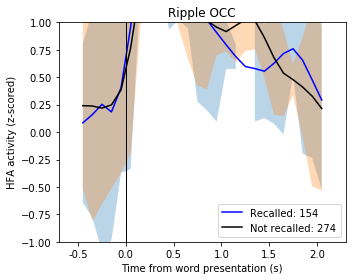

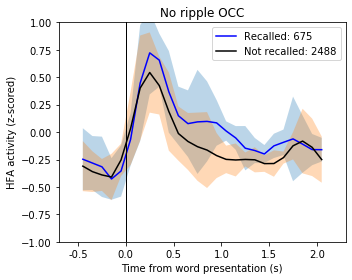

In [38]:
title_r = f'Ripple {region_name}'
title_nr = f'No ripple {region_name}'
savePath_SME_ripple_fig = f'updates/figures/ripple_HFA_wr_{region_name}'
savePath_SME_noripple_fig = f'updates/figures/no_ripple_HFA_wr_{region_name}'
temp_start_array_ripple, sub_name_array_ripple, sess_name_array_ripple = RS.plot_SME_HFA(1, title_r, savePath_SME_ripple_fig)
temp_start_array_noripple, sub_name_array_noripple, sess_name_array_noripple = RS.plot_SME_HFA(2, title_nr, savePath_SME_noripple_fig)

In [34]:
mem_model, ols_model = RS.SME_ripple_interaction(saveBool=False, savePath='')

Unique values in ripple array [0. 1.]
Number of events where a ripple occured 4937
Number of events with no ripples 12890


/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2115: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
 

In [35]:
RS.save_model_info(mem_model, f'updates/stats_results/mem_model_SME_{region_name}.csv')
RS.save_model_info(ols_model, f'updates/stats_results/OLS_model_SME_{region_name}.csv')

In [36]:
mem_model.summary()

/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2566: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
==========================================================================================
Model:                       MixedLM            Dependent Variable:            HFA_mean   
No. Observations:            17827              Method:                        REML       
No. Groups:                  24                 Scale:                         1.8352     
Min. group size:             120                Likelihood:                    -30774.3016
Max. group size:             3600               Converged:                     Yes        
Mean group size:             742.8                                                        
------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                       -0.158    0.027 -5.754 0.000 -0.211 -0.104
ripple_exists                                    0.975    0.113  8.638 0.000  0.754  1.196
word_recalled                                    0.139    0.046  3.000 0.003  0.048  0.229
ripple_exists:word_recalled                     -0.092                                    
subject Var                                      0.004    0.004                           
subject x ripple_exists Cov                     -0.000                                    
ripple_exists Var                                0.272    0.075                           
subject x word_recalled Cov                      0.002                                    
ripple_exists x word_recalled Cov               -0.055    0.018                           
word_recalled Var                                0.020    0.003                           
subject x ripple_exists:word_recalled Cov        0.004                                    
ripple_exists x ripple_exists:word_recalled Cov -0.001                                    
word_recalled x ripple_exists:word_recalled Cov  0.001                                    
ripple_exists:word_recalled Var                  0.005                                    
session Var                                      0.006    0.002                           
==========================================================================================

"""

In [45]:
math.floor(-1.5)

-2